In [298]:
!pip install catboost

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.9 MB/s eta 0:00:00


In [247]:
data = pd.read_csv('/content/train.csv')

In [248]:
data.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850


In [249]:
#make a copy of the original file/dataset. It is a good practice to modify the copy, not the original data
working_file = data.copy()


**STEP 1:  Data Exploration and Cleaning** <br>
*Explore the Dataset:* <br>Understand the structure of the dataset, check for any missing values, and get a sense of the distributions of numerical and categorical variables.
<br>
*Drop unnecessary columns:* <br> Remove columns with no meaningful purpose in predicting the target variable

In [250]:
working_file.shape

(54273, 13)

In [251]:
# check the dataset for missing values
working_file.isnull().sum()

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [252]:
working_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54273 entries, 0 to 54272
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            54273 non-null  int64 
 1   brand         54273 non-null  object
 2   model         54273 non-null  object
 3   model_year    54273 non-null  int64 
 4   milage        54273 non-null  int64 
 5   fuel_type     54273 non-null  object
 6   engine        54273 non-null  object
 7   transmission  54273 non-null  object
 8   ext_col       54273 non-null  object
 9   int_col       54273 non-null  object
 10  accident      54273 non-null  object
 11  clean_title   54273 non-null  object
 12  price         54273 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.4+ MB


In [253]:
working_file.describe()

,id,model_year,milage,price
count,54273.000000,54273.000000,54273.000000,5.427300e+04
mean,27136.000000,2015.091979,72746.175667,3.921844e+04
std,15667.409917,5.588909,50469.490448,7.282634e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,13568.000000,2012.000000,32268.000000,1.550000e+04
50%,27136.000000,2016.000000,66107.000000,2.800000e+04
75%,40704.000000,2019.000000,102000.000000,4.500000e+04
max,54272.000000,2024.000000,405000.000000,2.954083e+06


In [254]:
working_file.describe(include='object')

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,54273,54273,54273,54273,54273,54273,54273,54273,54273
unique,53,1827,7,1061,46,260,124,2,1
top,BMW,F-150 XLT,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,A/T,Black,Black,None reported,Yes
freq,7369,780,49439,1452,16757,15078,31820,39896,54273


In [255]:
#view unique values
for colum in working_file.columns:
    print(colum, ":", working_file[colum].unique(), "\n")

id : [    0     1     2 ... 54270 54271 54272] 

brand : ['Ford' 'BMW' 'Jaguar' 'Pontiac' 'Acura' 'Audi' 'GMC' 'Maserati'
 'Chevrolet' 'Porsche' 'Mercedes-Benz' 'Tesla' 'Lexus' 'Kia' 'Lincoln'
 'Dodge' 'Volkswagen' 'Land' 'Cadillac' 'Mazda' 'RAM' 'Subaru' 'Hyundai'
 'MINI' 'Jeep' 'Honda' 'Hummer' 'Nissan' 'Toyota' 'Volvo' 'Genesis'
 'Mitsubishi' 'Buick' 'INFINITI' 'McLaren' 'Scion' 'Lamborghini' 'Bentley'
 'Suzuki' 'Ferrari' 'Alfa' 'Rolls-Royce' 'Chrysler' 'Aston' 'Rivian'
 'Lotus' 'Saturn' 'Lucid' 'Mercury' 'Maybach' 'FIAT' 'Plymouth' 'Bugatti'] 

model : ['F-150 Lariat' '335 i' 'XF Luxury' ... 'Q4 e-tron Sportback Premium'
 'Countryman Cooper' 'S-10 LS'] 

model_year : [2018 2007 2009 2022 2001 2003 2014 2019 2016 2017 2013 2021 2015 2020
 2012 2006 2023 2011 2010 1999 2004 1993 2002 2005 2008 1995 1998 2000
 1997 1994 1996 2024 1992 1974] 

milage : [74349 80000 91491 ... 62850 82984 28750] 

fuel_type : ['Gasoline' 'Hybrid' 'E85 Flex Fuel' 'Diesel' '–' 'Plug-In Hybrid'
 'not suppor

In [256]:
working_file['clean_title'].value_counts()

clean_title
Yes    54273
Name: count, dtype: int64

In [257]:
working_file['engine'].value_counts()

engine
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    1452
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel             1125
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel             1054
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel             979
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel              893
                                                         ... 
4.4 Liter GDI DOHC Twin Turbo                               1
3.0 Liter Twin Turbo                                        1
150.0HP 2.0L 4 Cylinder Engine Diesel Fuel                  1
266.0HP Electric Motor Electric Fuel System                 1
151.0HP Electric Motor Hydrogen Fuel                        1
Name: count, Length: 1061, dtype: int64

In [258]:
working_file['transmission'].value_counts()

transmission
A/T                                                   16757
8-Speed A/T                                            7287
Transmission w/Dual Shift Mode                         6454
6-Speed A/T                                            5944
6-Speed M/T                                            3618
7-Speed A/T                                            3415
10-Speed A/T                                           2187
8-Speed Automatic                                      1189
5-Speed A/T                                            1185
9-Speed A/T                                            1073
4-Speed A/T                                             764
5-Speed M/T                                             718
CVT Transmission                                        692
10-Speed Automatic                                      642
6-Speed Automatic                                       516
Automatic                                               441
M/T                        

In [259]:
# save the id column for future use
id_column = working_file['id']

In [260]:
'''The id column typically serves as a unique identifier for each row
and does not provide any predictive value for the vehicle price. '''

'''Since the clean_title column has the same value ('Yes') for the entire dataset,
  it doesn't provide any variance or useful information for the predictive model.
  In this case, it's best to remove this column from the dataset to avoid unnecessary complexity'''


#Therefore, both can be dropped from the dataset.
working_file = working_file.drop(['id','clean_title'], axis=1)


In [261]:
working_file.head(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,11000
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,8250


In [262]:
working_file.shape

(54273, 11)

**Step 2: Feature Engineering** <br>
*Feature Extraction:* <br>Extract useful features from existing columns.

In [265]:
# create a function to extract the valuable information from columns, create new features
def create_new_features(df):

    # Extract horsepower
    df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)

    # Extract engine size
    df['engine_size'] = df['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)

    # Extract cylinder count
    df['cylinder_count'] = df['engine'].str.extract(r'(\d+) Cylinder').astype(float)

    # Extract fuel type
    df['fuel_type'] = df['engine'].str.extract(r'(Gasoline|Diesel|Electric|Hydrogen) Fuel')

    # Handle cases without explicit engine size or cylinder count
    df['engine_size'] = df['engine_size'].fillna(df['engine'].str.extract(r'(\d+\.?\d*) Liter')[0].astype(float))
    df['fuel_type'] = df['fuel_type'].fillna(df['engine'].str.extract(r'(Electric|Hybrid)')[0])

    # Fill missing values in 'cylinder_count' with 0 for electric engines
    df['cylinder_count'] = df['cylinder_count'].fillna(0)

    # Create engine type feature
    def engine_type(engine_description):
        if 'Turbo' in engine_description:
            return 'Turbocharged'
        elif 'Electric' in engine_description:
            return 'Electric'
        elif 'Hybrid' in engine_description:
            return 'Hybrid'
        else:
            return 'Conventional'

    df['engine_type'] = df['engine'].apply(engine_type)

    # Add vehicle age
    current_year = datetime.now().year
    df['vehicle_age'] = current_year - df['model_year']

    # Add mileage per year
    df['mileage_per_year'] = df['milage'] / df['vehicle_age']
    df['mileage_per_year'] = df['mileage_per_year'].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Add brand and model popularity features
    brand_counts = df['brand'].value_counts().to_dict()
    model_counts = df['model'].value_counts().to_dict()
    df['brand_popularity'] = df['brand'].map(brand_counts)
    df['model_popularity'] = df['model'].map(model_counts)

    # Nested function to classify transmission type
    def classify_transmission(transmission):
        if 'M/T' in transmission or 'Manual' in transmission:
            return 'Manual'
        elif 'A/T' in transmission or 'Automatic' in transmission or 'CVT' in transmission:
            return 'Automatic'
        else:
            return 'Other'

    # Nested function to extract the number of speeds
    def extract_speeds(transmission):
        match = re.search(r'(\d+)-Speed', transmission)
        if match:
            return int(match.group(1))
        else:
            return None

    # Transmission feature engineering
    df['transmission_type'] = df['transmission'].apply(classify_transmission)
    df['number_of_speeds'] = df['transmission'].apply(extract_speeds)
    df['is_dual_shift'] = df['transmission'].apply(lambda x: 1 if 'Dual Shift' in x else 0)
    df['is_cvt'] = df['transmission'].apply(lambda x: 1 if 'CVT' in x else 0)

    # Fill missing values
    df['fuel_type'] = df['fuel_type'].fillna('Unknown')
    df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())
    df['engine_size'] = df['engine_size'].fillna(df['engine_size'].median())
    df['number_of_speeds'] = df['number_of_speeds'].fillna(-1)  # Use -1 to indicate unknown number of speeds

    # Drop the original columns
    df = df.drop(columns=['engine', 'model_year', 'milage', 'brand', 'model', 'transmission'])

    return df


In [267]:
#execute the function above
working_file = create_new_features(working_file)

In [268]:
working_file.head(5)

,fuel_type,ext_col,int_col,accident,price,horsepower,engine_size,cylinder_count,engine_type,vehicle_age,mileage_per_year,brand_popularity,model_popularity,transmission_type,number_of_speeds,is_dual_shift,is_cvt
0,Gasoline,Blue,Gray,None reported,11000,375.0,3.5,6.0,Conventional,6,12391.500000,6706,496,Automatic,10.0,0,0
1,Gasoline,Black,Black,None reported,8250,300.0,3.0,6.0,Conventional,17,4705.882353,7369,229,Manual,6.0,0,0
2,Gasoline,Purple,Beige,None reported,15000,300.0,4.2,8.0,Conventional,15,6099.400000,661,21,Automatic,6.0,0,0
3,Electric,Gray,Brown,None reported,63500,335.0,3.0,6.0,Electric,2,1218.500000,7369,180,Other,-1.0,1,0
4,Gasoline,White,Black,None reported,7850,200.0,3.8,6.0,Conventional,23,4826.086957,149,16,Automatic,-1.0,0,0


In [269]:
working_file.shape

(54273, 17)

In [270]:
working_file.isnull().sum()

fuel_type            0
ext_col              0
int_col              0
accident             0
price                0
horsepower           0
engine_size          0
cylinder_count       0
engine_type          0
vehicle_age          0
mileage_per_year     0
brand_popularity     0
model_popularity     0
transmission_type    0
number_of_speeds     0
is_dual_shift        0
is_cvt               0
dtype: int64

**Step 3: Data Visualization**

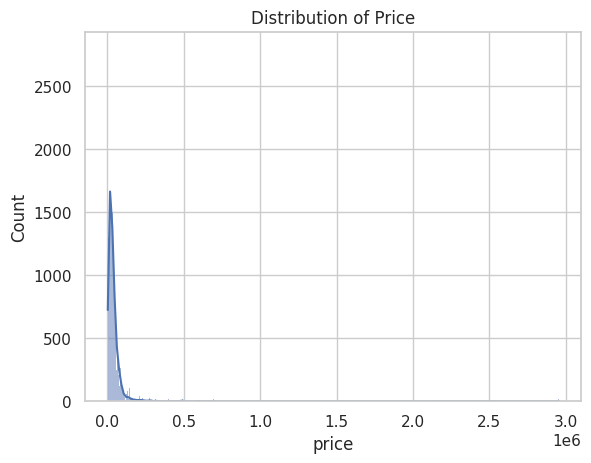

In [271]:
# Set the aesthetics for seaborn
sns.set(style='whitegrid')

# Distribution Plot
sns.histplot(working_file['price'], kde=True)
plt.title('Distribution of Price')
plt.show()

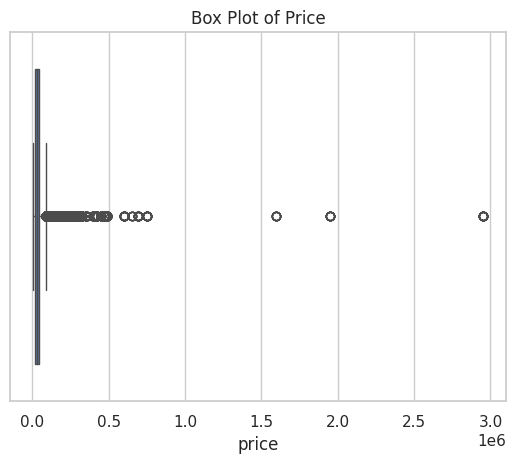

In [272]:
# Box Plot
sns.boxplot(x='price', data=working_file)
plt.title('Box Plot of Price')
plt.show()

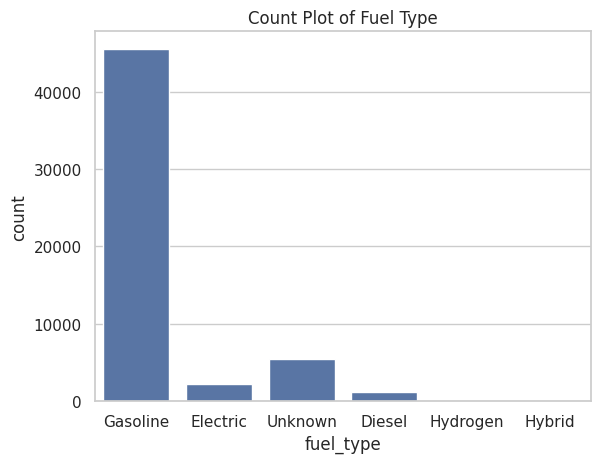

In [273]:
# Count Plot
sns.countplot(x='fuel_type', data=working_file)
plt.title('Count Plot of Fuel Type')
plt.show()

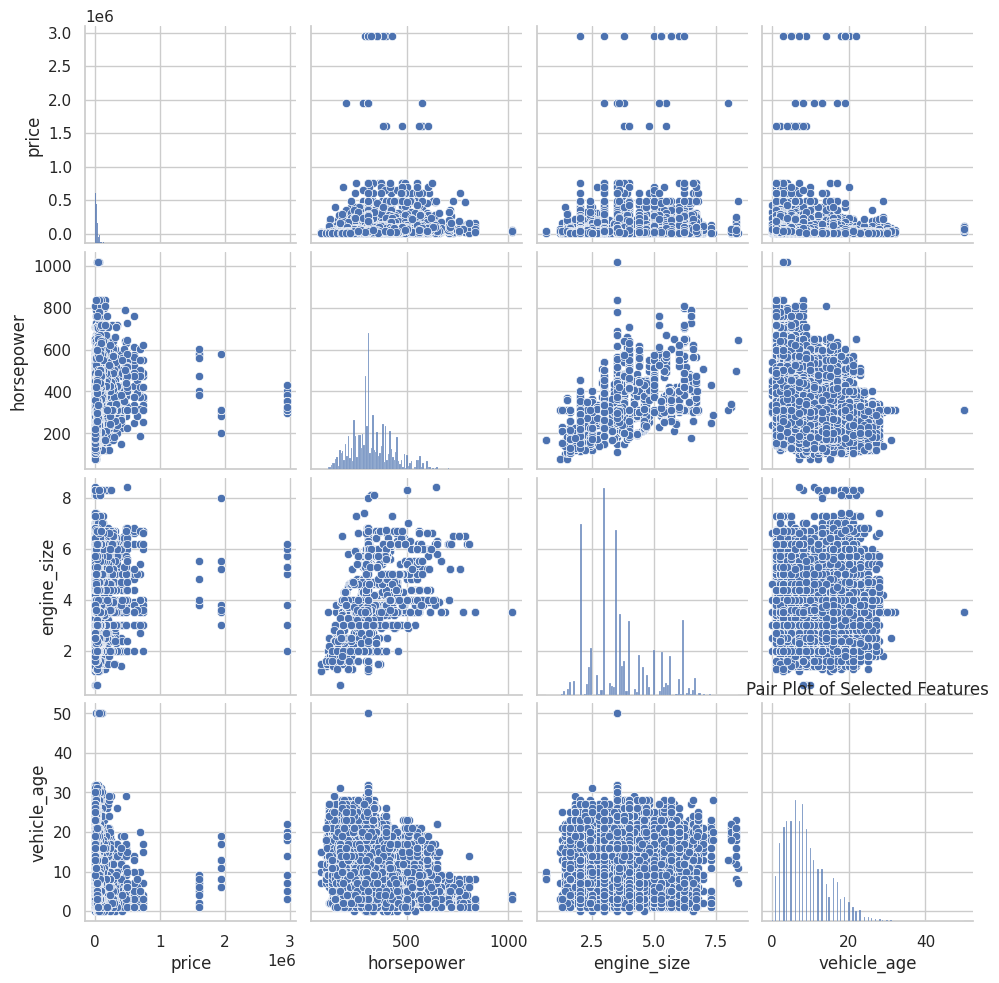

In [274]:
# Pair Plot
selected_features = ['price', 'horsepower', 'engine_size', 'vehicle_age']
sns.pairplot(working_file[selected_features])
plt.title('Pair Plot of Selected Features')
plt.show()

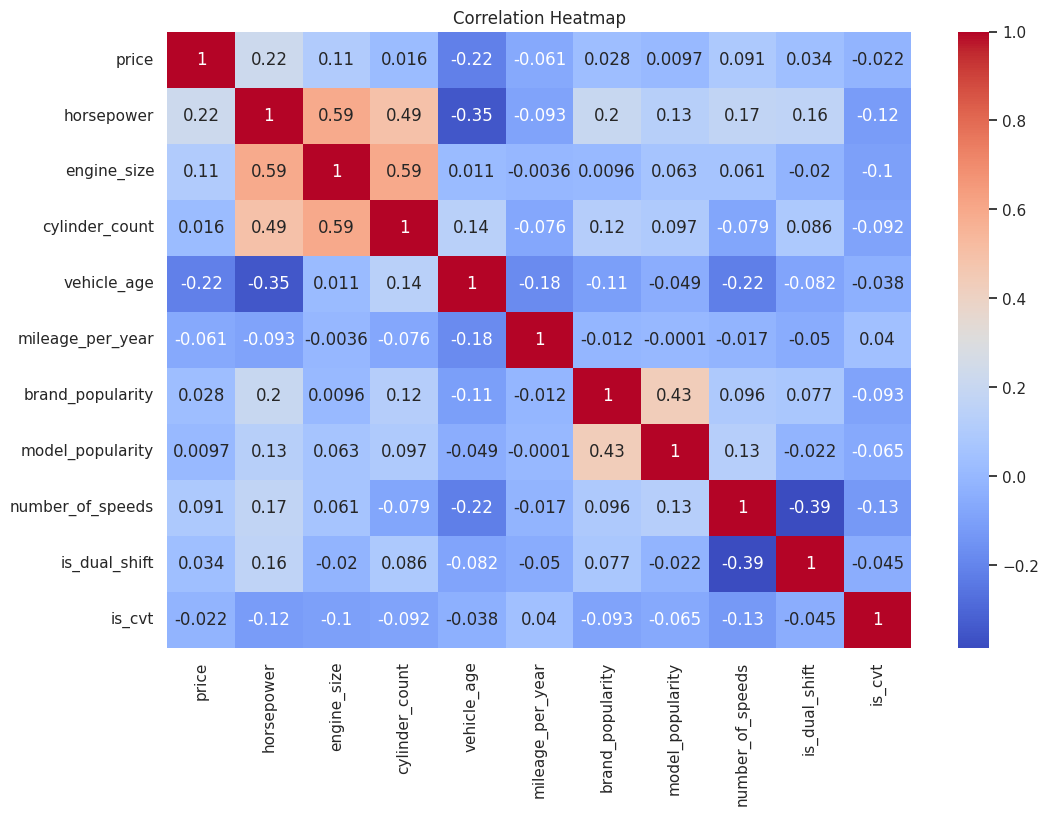

In [275]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
# Select only numerical columns for correlation calculation
numerical_working_file = working_file.select_dtypes(include=['float', 'int'])
correlation_matrix = numerical_working_file.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

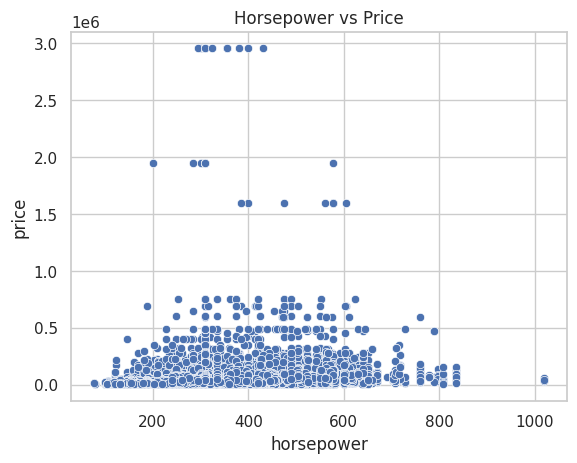

In [276]:
# Scatter Plot
sns.scatterplot(x='horsepower', y='price', data=working_file)
plt.title('Horsepower vs Price')
plt.show()

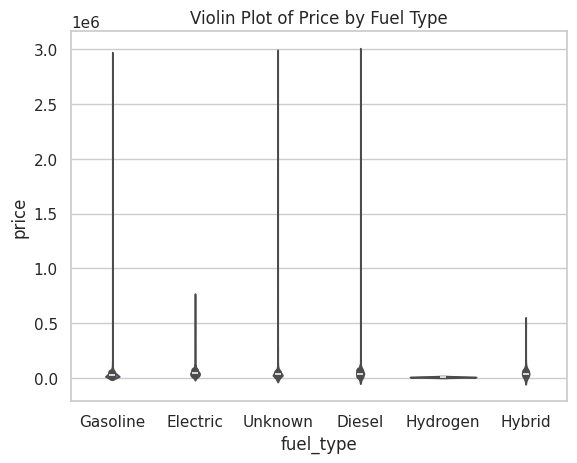

In [277]:
# Violin Plot
sns.violinplot(x='fuel_type', y='price', data=working_file)
plt.title('Violin Plot of Price by Fuel Type')
plt.show()

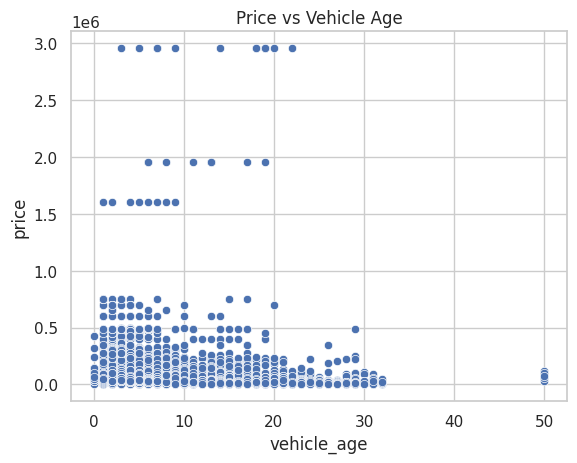

In [278]:
# Scatter plot for price vs vehicle_age
sns.scatterplot(x='vehicle_age', y='price', data=working_file)
plt.title('Price vs Vehicle Age')
plt.show()

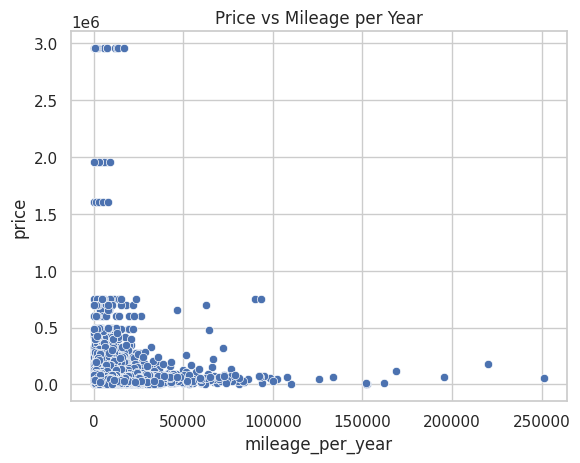

In [279]:
# Scatter plot for price vs mileage_per_year
sns.scatterplot(x='mileage_per_year', y='price', data=working_file)
plt.title('Price vs Mileage per Year')
plt.show()

**Step 4: Define features/target and Split the dataset** <br>

In [280]:
working_file.shape

(54273, 17)

In [281]:
# Define features and target
X = working_file.drop(columns=['price'])
y = working_file['price']

In [282]:
X.columns

Index(['fuel_type', 'ext_col', 'int_col', 'accident', 'horsepower',
       'engine_size', 'cylinder_count', 'engine_type', 'vehicle_age',
       'mileage_per_year', 'brand_popularity', 'model_popularity',
       'transmission_type', 'number_of_speeds', 'is_dual_shift', 'is_cvt'],
      dtype='object')

In [283]:
X.shape

(54273, 16)

In [284]:
y.shape

(54273,)

In [285]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [286]:
print('Features size')
print(X_train.shape, 'train')
print(X_val.shape, 'validation')
print(X_test.shape, 'test')
print('--------------------')
print('Target size')
print(y_train.shape, 'train')
print(y_val.shape, 'validation')
print(y_test.shape, 'test')

Features size
(37991, 16) train
(8141, 16) validation
(8141, 16) test
--------------------
Target size
(37991,) train
(8141,) validation
(8141,) test


In [288]:
# Define numerical features
numerical_features = X.select_dtypes(include=[np.number])
numerical_features

,horsepower,engine_size,cylinder_count,vehicle_age,mileage_per_year,brand_popularity,model_popularity,number_of_speeds,is_dual_shift,is_cvt
0,375.0,3.5,6.0,6,12391.500000,6706,496,10.0,0,0
1,300.0,3.0,6.0,17,4705.882353,7369,229,6.0,0,0
2,300.0,4.2,8.0,15,6099.400000,661,21,6.0,0,0
3,335.0,3.0,6.0,2,1218.500000,7369,180,-1.0,1,0
4,200.0,3.8,6.0,23,4826.086957,149,16,-1.0,0,0
...,...,...,...,...,...,...,...,...,...,...
54268,445.0,4.4,8.0,7,4142.857143,7369,49,8.0,0,0
54269,220.0,2.0,4.0,9,10514.888889,2922,164,6.0,0,0
54270,420.0,3.6,6.0,11,3726.272727,2627,112,-1.0,1,0
54271,310.0,4.0,0.0,1,1518.000000,2627,19,8.0,0,0


In [289]:
# Define categorical features
categorical_features = X.select_dtypes(include=['object', 'category'])
categorical_features

,fuel_type,ext_col,int_col,accident,engine_type,transmission_type
0,Gasoline,Blue,Gray,None reported,Conventional,Automatic
1,Gasoline,Black,Black,None reported,Conventional,Manual
2,Gasoline,Purple,Beige,None reported,Conventional,Automatic
3,Electric,Gray,Brown,None reported,Electric,Other
4,Gasoline,White,Black,None reported,Conventional,Automatic
...,...,...,...,...,...,...
54268,Gasoline,White,Brown,None reported,Conventional,Automatic
54269,Unknown,Black,Black,At least 1 accident or damage reported,Conventional,Automatic
54270,Gasoline,White,Black,At least 1 accident or damage reported,Conventional,Other
54271,Unknown,Beige,Brown,None reported,Conventional,Automatic


**Step 5: Preprocessing**

In [294]:
# Function to create preprocessing pipeline
def create_preprocessing_pipeline(numerical_features, categorical_features):
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor

In [295]:
# execute the preprocessing function

preprocessor = create_preprocessing_pipeline(numerical_features, categorical_features)


**Step 6: # Define models to compare**

In [299]:
# Create a list of models to compare
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('XGBoost', XGBRegressor(eval_metric='rmse')),
    ('LightGBM', LGBMRegressor()),
    ('CatBoost', CatBoostRegressor(verbose=0)),
    ('Support Vector Regressor', SVR()),
    ('K-Neighbors Regressor', KNeighborsRegressor()),
    ('MLP Regressor', MLPRegressor(max_iter=1000))
]

In [ ]:
# # Create the submission file
# submission = pd.DataFrame({'id': id_column, 'price': predicted_prices})
